Ζαχαριουδάκη Αικατερίνη Μεθοδία

ΑΜ 1115201900060

In [ ]:
import re
import random
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import get_linear_schedule_with_warmup
import torch
import torch.nn as nn
from torch.optim import Adam, AdamW
import optuna
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc

os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

## Reproducibility

In [2]:
def torch_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
torch_seed(42)

## Load Data

In [3]:
# local input
# train_data = pd.read_csv('train_dataset.csv')
# val_data = pd.read_csv('val_dataset.csv')
# test_data = pd.read_csv('test_dataset.csv')

# kaggle input
train_data = pd.read_csv('/kaggle/input/ai-2-dl-for-nlp-2025-homework-3/train_dataset.csv')
val_data = pd.read_csv('/kaggle/input/ai-2-dl-for-nlp-2025-homework-3/val_dataset.csv')
test_data = pd.read_csv('/kaggle/input/ai-2-dl-for-nlp-2025-homework-3/test_dataset.csv')

## Text Preprocessing

In [ ]:
def preprocess_text(text):
    text = text.lower()

    # remove tags, urls, html entities, emails, time
    text,_ = re.subn(r'\B@\S+', ' user ', text)
    text,_ = re.subn(r'https?:\S+', ' url ', text)
    text,_ = re.subn(r'www.\S+', ' url ', text)
    text,_ = re.subn(r'&\w+;', '', text)
    text,_ = re.subn(r'\S+@\S+\.\S+', '', text)
    text,_ = re.subn(r'([0-1]?[0-9]|[2][0-3]):([0-5][0-9])0', ' time ', text)

    # remove excess whitespace
    text,_ = re.subn(r'\s+', ' ', text)

    return text

train_data['Text'] = train_data['Text'].apply(preprocess_text)
val_data['Text'] = val_data['Text'].apply(preprocess_text)
test_data['Text'] = test_data['Text'].apply(preprocess_text)

In [5]:
train_tweets = train_data.Text.values
val_tweets = val_data.Text.values
test_tweets = test_data.Text.values

train_labels = train_data.Label.values
val_labels = val_data.Label.values

## Load Tokenizer

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Below we have the mean length and the longest tweet in tokens of the three datasets

In [7]:
max_len = 0
mean_len = 0
for tweet in train_tweets:
    input_ids = tokenizer.encode(tweet, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
    mean_len += len(input_ids)
mean_len /= len(train_tweets)
print(f'Mean length of train tweets: {mean_len}')
print(f'Max length of train tweets: {max_len}')
mean_len = 0
max_len = 0
for tweet in val_tweets:
    input_ids = tokenizer.encode(tweet, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
    mean_len += len(input_ids)
mean_len /= len(val_tweets)
print(f'Mean length of validation tweets: {mean_len}')
print(f'Max length of validation tweets: {max_len}')
mean_len = 0
max_len = 0
for tweet in test_tweets:
    input_ids = tokenizer.encode(tweet, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
    mean_len += len(input_ids)
mean_len /= len(test_tweets)
print(f'Mean length of test tweets: {mean_len}')
print(f'Max length of test tweets: {max_len}')

Mean length of train tweets: 20.32872604253713
Max length of train tweets: 256
Mean length of validation tweets: 20.361567128974432
Max length of validation tweets: 154
Mean length of test tweets: 20.460257559318837
Max length of test tweets: 294


## Datasets and Dataloaders

In [8]:
train_dataset = []

for tweet, label in zip(train_tweets, train_labels):
    encoded_dict = tokenizer.encode_plus(
        tweet,
        add_special_tokens=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    encoded_dict['input_ids'] = encoded_dict['input_ids'].squeeze(0)
    encoded_dict['attention_mask'] = encoded_dict['attention_mask'].squeeze(0)
    encoded_dict.pop('token_type_ids')
    encoded_dict['labels'] = torch.tensor(label)
    train_dataset.append(encoded_dict)



val_dataset = []

for tweet, label in zip(val_tweets, val_labels):
    encoded_dict = tokenizer.encode_plus(
        tweet,
        add_special_tokens=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    encoded_dict['input_ids'] = encoded_dict['input_ids'].squeeze(0)
    encoded_dict['attention_mask'] = encoded_dict['attention_mask'].squeeze(0)
    encoded_dict.pop('token_type_ids')
    encoded_dict['labels'] = torch.tensor(label)
    val_dataset.append(encoded_dict)


test_dataset = []

for tweet in test_tweets:
    encoded_dict = tokenizer.encode_plus(
        tweet,
        add_special_tokens=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    encoded_dict['input_ids'] = encoded_dict['input_ids'].squeeze(0)
    encoded_dict['attention_mask'] = encoded_dict['attention_mask'].squeeze(0)
    encoded_dict.pop('token_type_ids')
    test_dataset.append(encoded_dict)

In [9]:
torch_seed(42)
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, sampler=RandomSampler(train_dataset), batch_size=32)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, sampler=SequentialSampler(val_dataset), batch_size=32)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, sampler=SequentialSampler(test_dataset), batch_size=32)

## Evaluation function

In [10]:
def evaluation(dataloader, model, device, printing=False, plotting=False):
    model.eval()
    total_eval_loss = 0
    predictions = []
    labels = []

    for batch in dataloader:
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.no_grad():
            result = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels, return_dict=True)
        
        loss = result.loss
        logits = result.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        pred = np.argmax(logits, axis=1).flatten()
        predictions.extend(pred)
        label_ids = b_labels.to('cpu').numpy().flatten()
        labels.extend(label_ids)

    avg_val_loss = total_eval_loss / len(dataloader)
    f1 = f1_score(labels, predictions)
    accuracy = accuracy_score(labels, predictions)
    confmatrix = confusion_matrix(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)

    if printing:
        print(f"Loss: {avg_val_loss}")
        print(f'Accuracy: {accuracy}')
        print(f'F1-score: {f1}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(f'Confusion Matrix: \n{confmatrix}')

    if plotting:
        fpr, tpr, thresholds = roc_curve(labels, predictions) 
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()
        
    return avg_val_loss, accuracy

## Training function

In [11]:
def training(epochs, optimizer, scheduler, dataloader, model, device, val_dataloader, printing=True, plotting=True):
    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
        model.train()
        total_train_loss = 0
        for step, batch in enumerate(dataloader):
            if step % 400 == 0 and not step == 0 and printing:
                print(f'Batch {step:<2} of {len(dataloader)}')


            b_input_ids = batch['input_ids'].to(device)
            b_input_mask = batch['attention_mask'].to(device)
            b_labels = batch['labels'].to(device)

            model.zero_grad()

            result = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels, return_dict=True)

            loss = result.loss
            logits = result.logits
            total_train_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(dataloader)
        train_loss.append(avg_train_loss)
        val_loss_epoch, _ = evaluation(val_dataloader, model, device, printing=False)
        val_loss.append(val_loss_epoch)

        if printing:
            print(f'Epoch {epoch:<2} : Loss = {avg_train_loss}')

    if plotting:   
        plt.plot(train_loss, label='Train Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss Plot')
        plt.legend()
        plt.show()

    return model

## Load model

In [12]:
torch_seed(42)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2, output_attentions=False, output_hidden_states=False)
model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

======== Epoch 1 / 2 ========
Batch 400 of 4638
Batch 800 of 4638
Batch 1200 of 4638
Batch 1600 of 4638
Batch 2000 of 4638
Batch 2400 of 4638
Batch 2800 of 4638
Batch 3200 of 4638
Batch 3600 of 4638
Batch 4000 of 4638
Batch 4400 of 4638
Epoch 0  : Loss = 0.3797595004031837
======== Epoch 2 / 2 ========
Batch 400 of 4638
Batch 800 of 4638
Batch 1200 of 4638
Batch 1600 of 4638
Batch 2000 of 4638
Batch 2400 of 4638
Batch 2800 of 4638
Batch 3200 of 4638
Batch 3600 of 4638
Batch 4000 of 4638
Batch 4400 of 4638
Epoch 1  : Loss = 0.24766044425663633


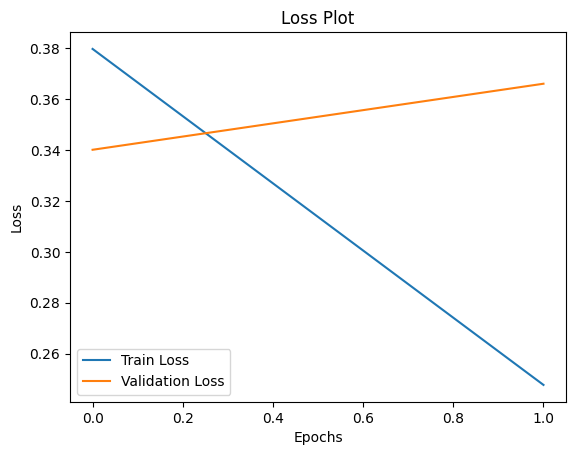

In [13]:
torch_seed(42)
device = 'cuda'

epochs = 2
total_steps = len(train_dataloader) * epochs
optimizer = Adam(model.parameters(), lr=4e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

model = training(epochs, optimizer, scheduler, train_dataloader, model, device, val_dataloader)

Loss: 0.36607956537660563
Accuracy: 0.8558826304368337
F1-score: 0.8553366796098115
Precision: 0.8586300327993536
Recall: 0.8520684937968772
Confusion Matrix: 
[[18223  2974]
 [ 3136 18063]]


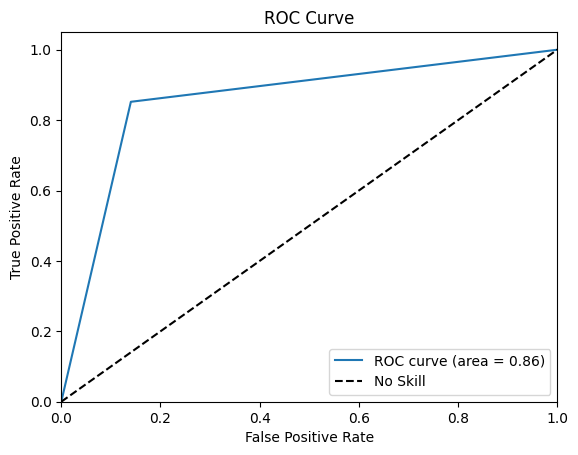

In [14]:
_ = evaluation(val_dataloader, model, device, printing=True, plotting=True)

In [15]:
def testing(dataloader, model, device):
    model.eval()

    predictions = []

    for batch in dataloader:
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)

        with torch.no_grad():
            result = model(b_input_ids, attention_mask=b_input_mask, return_dict=True)
                
        logits = result.logits

        logits = logits.detach().cpu().numpy()
        pred = np.argmax(logits, axis=1).flatten()
        predictions.extend(pred)

    output = pd.DataFrame(test_data['ID'])
    output['Label'] = predictions
    output.to_csv('submission.csv', index=False)

testing(test_dataloader, model, device)

## Hyper-parameter tuning

Below is the code for the hyper-parameter tuning using the optuna framework. We are tuning the optimizer and the number of epochs.

In [16]:
# def objective(trial):
#     torch_seed(42)
#     model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2, output_attentions=False, output_hidden_states=False)
#     model.cuda();
#     epochs = trial.suggest_int('epochs', 2, 4)
#     opt = trial.suggest_categorical('optimizer', [Adam, AdamW])
#     lr = trial.suggest_float('learning_rate', 1e-5, 5e-5, step=1e-5)
#     optimizer = opt(model.parameters(), lr=lr, eps=1e-8)
    
#     total_steps = len(train_dataloader) * epochs
#     scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

#     model_trained = training(epochs, optimizer, scheduler, train_dataloader, model, device='cuda', val_dataloader=val_dataloader, printing=False)
    
#     _, accuracy = evaluation(val_dataloader, model_trained, device='cuda', printing=False)

#     return accuracy

# sampler = optuna.samplers.TPESampler(multivariate=True, seed=13)
# study = optuna.create_study(direction='maximize', sampler=sampler)

# study.optimize(objective, n_trials=5, show_progress_bar=True, gc_after_trial=True)

# print('Best accuracy: ', study.best_trial.value)
# print('Best trial: ', study.best_trial.params)